In [1]:
import numpy as np
import xarray as xr
import os
import matplotlib as mpl
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
plt.style.use('./grl.mplstyle')

%load_ext autoreload
%autoreload 3
    
DATAPATH = '/scratch/jw8736/ctr/outputs/'

### Read in 3D fields and compute phase averaged fields

In [2]:
''' Load all 3D fields together. '''

import os
import glob

def load(path):
    files = sorted(glob.glob(os.path.join(path, 'field_eta_t*.nc')))  # Use wildcard to find all matching files
    
    # Parsing the filename to get a time
    def preprocess(ds, fname):
        t = float(os.path.basename(fname).split('_t')[1].split('.nc')[0])
        ds = ds.expand_dims({'t': [t]})  # Add new dimension 'year'
        return ds
    
    # Use open_mfdataset with preprocess function and the wildcard
    ds = xr.open_mfdataset(files, concat_dim='t', combine='nested', preprocess=lambda ds: preprocess(ds, ds.encoding['source']),
                           chunks={'x':-1,'z':-1,'y':-1})
    
    # We transform y coordinate!
    wl = 2*np.pi/4
    ds['y'] = (ds['y'] - 1) / wl
    print(ds)
    return ds

In [3]:
path = DATAPATH + 'CU4/netcdf/'
ds = load (path)

# path = DATAPATH + 'CU8/netcdf/'
# ds = load (path)

# path = DATAPATH + 'NWP_ZPG_CU4/netcdf/'
# ds = load (path)

# path = DATAPATH + 'NWP_ZPG_CU8/netcdf/'
# ds = load(path)

<xarray.Dataset>
Dimensions:  (t: 20, z: 512, x: 512, y: 512)
Coordinates:
  * t        (t) float64 39.0 40.0 41.0 42.0 43.0 ... 54.0 55.0 56.0 57.0 58.0
  * x        (x) float64 -3.135 -3.123 -3.111 -3.099 ... 3.099 3.111 3.123 3.135
  * y        (y) float64 -0.6327 -0.6249 -0.6171 -0.6093 ... 3.344 3.352 3.359
  * z        (z) float64 -3.135 -3.123 -3.111 -3.099 ... 3.099 3.111 3.123 3.135
Data variables:
    ux       (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    uy       (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    uz       (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    f        (t, z, x, y) float32 dask.array<chunksize=(1, 512, 512, 512), meta=np.ndarray>
    eta      (t, z, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    phase    (t, x) float32 dask.array<chunksize=(1, 512), meta=np.ndarray>
Attributes:
    start_time:  40
    ak:          0.2
    k:  

In [4]:
nbins = 64
bins = np.linspace(-np.pi, np.pi, nbins + 1)  # num_bins+1 for edges
bin_centers = (bins[:-1] + bins[1:]) / 2

ds_ = ds.sel(t=slice(50,58))
# ds_ = ds.sel(t=slice(45,58))

with ProgressBar():
    ux_wave = ds_['ux'].groupby_bins(ds_.phase, bins=bins).mean().mean(['z']).compute()
    uy_wave = ds_['uy'].groupby_bins(ds_.phase, bins=bins).mean().mean(['z']).compute()

/ext3/miniconda3/lib/python3.11/site-packages/xarray/core/dataset.py:4597: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  stacked_var = exp_var.stack(**{new_dim: dims})


[########################################] | 100% Completed | 406.18 ms
[                                        ] | 0% Completed | 130.06 us

/ext3/miniconda3/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


[########################################] | 100% Completed | 34.21 s
[########################################] | 100% Completed | 108.51 ms


/ext3/miniconda3/lib/python3.11/site-packages/xarray/core/dataset.py:4597: PerformanceWarning: Reshaping is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array.reshape(shape)

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array.reshape(shape)Explictly passing ``limit`` to ``reshape`` will also silence this warning
    >>> array.reshape(shape, limit='128 MiB')
  stacked_var = exp_var.stack(**{new_dim: dims})
/ext3/miniconda3/lib/python3.11/site-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


[########################################] | 100% Completed | 35.13 s


In [15]:
####### Check how phase averaging depends on sampling window #######
####### Difference seems really small #######

# nbins = 64
# bins = np.linspace(-np.pi, np.pi, nbins + 1)  # num_bins+1 for edges
# bin_centers = (bins[:-1] + bins[1:]) / 2

# ds_ = ds.sel(t=slice(50,59))

# with ProgressBar():
#     ux_wave1 = ds_['ux'].groupby_bins(ds_.phase, bins=bins).mean().mean(['z']).compute()
#     uy_wave1 = ds_['uy'].groupby_bins(ds_.phase, bins=bins).mean().mean(['z']).compute()

# ds_ = ds.sel(t=slice(51,59))

# with ProgressBar():
#     ux_wave2 = ds_['ux'].groupby_bins(ds_.phase, bins=bins).mean().mean(['z']).compute()
#     uy_wave2 = ds_['uy'].groupby_bins(ds_.phase, bins=bins).mean().mean(['z']).compute()

In [23]:
#### Manually record the window used for phase computation ####
wave = xr.Dataset(
    data_vars={
        'u_wave':(['y','phase'],ux_wave.values),
        'v_wave':(['y','phase'],uy_wave.values)},
    coords={
        'y':ux_wave.y.values,
        'phase':bin_centers
    },
    attrs={'ave_time_window':(45,57)}
)

wave.to_netcdf(path + 'wave.nc')

In [ ]:
u_wave_interp = wave.u_wave.interp(phase=ds_.phase, kwargs={"fill_value": "extrapolate"})
v_wave_interp = wave.v_wave.interp(phase=ds_.phase, kwargs={"fill_value": "extrapolate"})

### Figure: triple decomposition

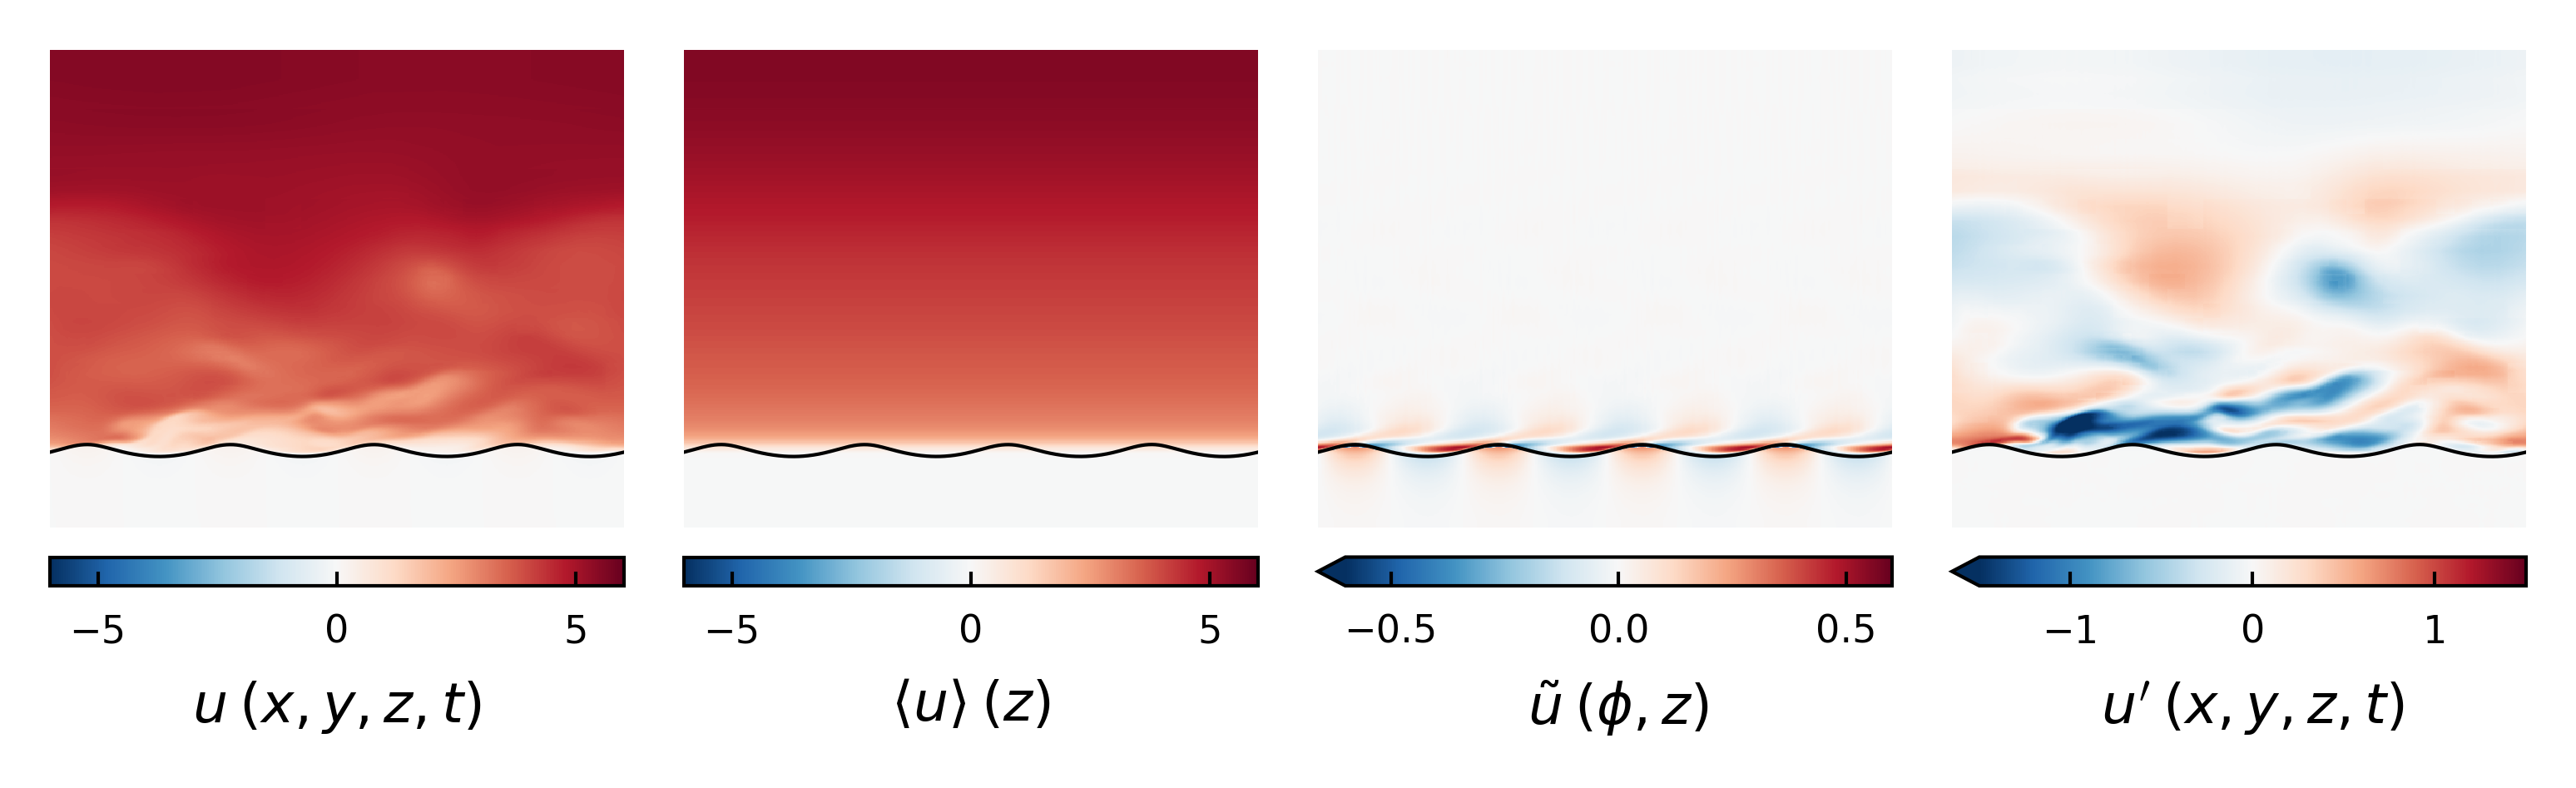

In [7]:
fig,axes = plt.subplots(1,4,figsize=[5.2,1.6])

tc = 0; zc = 250

ax = axes[0]
ds_.ux.isel(t=tc,z=zc).plot(x='x', ax=ax, vmax=6, vmin=-6, cmap='RdBu_r',
                            cbar_kwargs={'orientation':'horizontal','label':r'$u\:(x,y,z,t)$','pad':0.05})

ax = axes[1]
u_mean_plot = u_wave_interp.isel(t=tc).mean('x')*u_wave_interp.isel(t=tc)/u_wave_interp.isel(t=tc)
u_mean_plot.plot(x='x', ax=ax, vmax=6, vmin=-6, cmap='RdBu_r',
                 cbar_kwargs={'orientation':'horizontal','label':r'$\langle u \rangle\:(z)$','pad':0.05})

ax = axes[2]
# u_wave_plot = (u_wave_interp.isel(t=0) - u_mean_plot)*(1-ds_.f.isel(t=tc).mean('z'))
u_wave_plot = (u_wave_interp.isel(t=tc) - u_mean_plot*(1-ds_.f.isel(t=tc).mean('z')**5))
u_wave_plot.plot(x='x', ax=ax, vmax=0.6, vmin=-0.6, cmap='RdBu_r',
                 cbar_kwargs={'orientation':'horizontal','label':r'$\tilde{u}\:(\phi,z)$','pad':0.05})

ax = axes[3]
u_turb = (ds_.ux.isel(t=tc,z=zc) - u_wave_interp.isel(t=tc)) # Random t and z
u_turb.plot(x='x', ax=ax, vmax=1.5, vmin=-1.5, cmap='RdBu_r',
            cbar_kwargs={'orientation':'horizontal','label':r'$u^{\prime}\:(x,y,z,t)$','pad':0.05})

for ax in axes:
    (ds_.eta-1).isel(t=tc,z=zc).plot(x='x', ax=ax, c='k', lw=0.5)
    ax.axis('off'); ax.set_title('')

plt.tight_layout()
# fig.savefig('../../plots/u_tri.png', bbox_inches='tight')

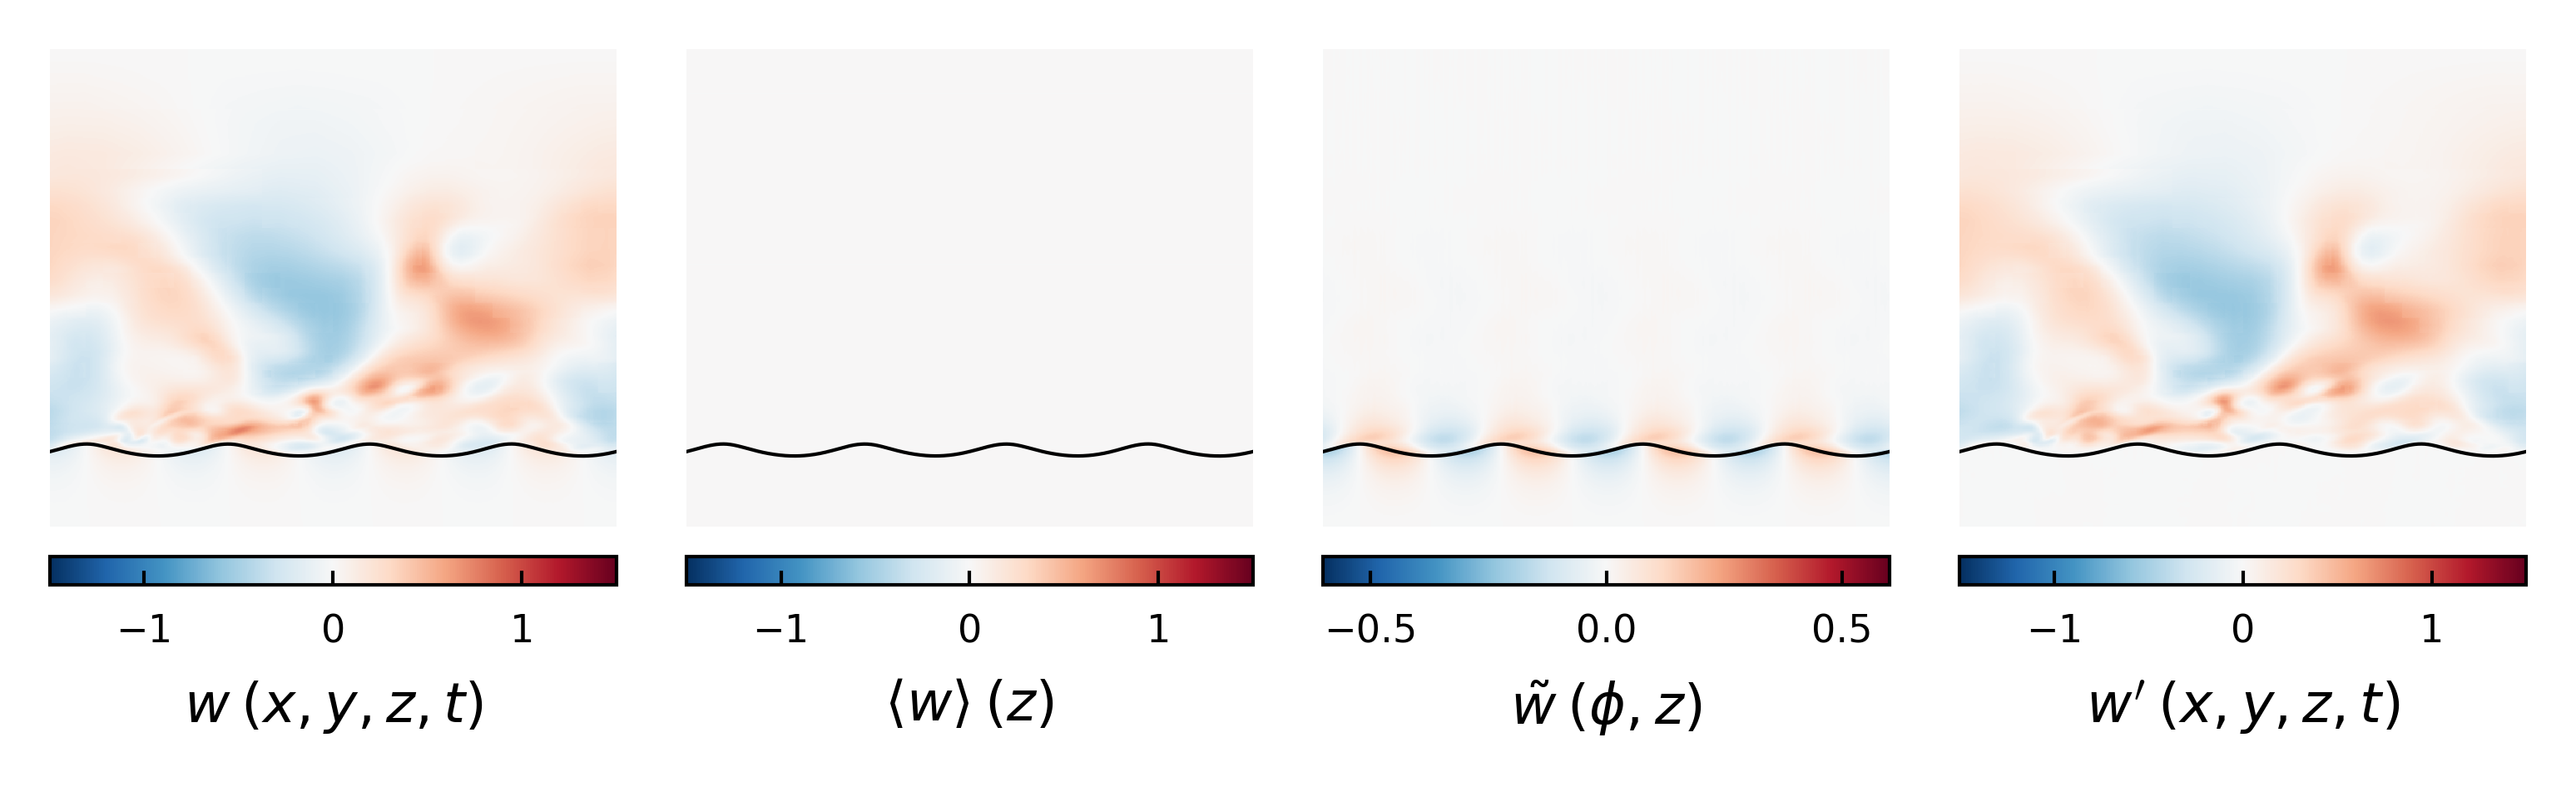

In [23]:
fig,axes = plt.subplots(1,4,figsize=[5.2,1.6])

tc = 0; zc = 250

ax = axes[0]
ds_.uy.isel(t=tc,z=zc).plot(x='x', ax=ax, vmax=1.5, vmin=-1.5, cmap='RdBu_r',
                            cbar_kwargs={'orientation':'horizontal','label':r'$w\:(x,y,z,t)$','pad':0.05})

ax = axes[1]
v_mean_plot = v_wave_interp.isel(t=tc).mean('x')*v_wave_interp.isel(t=tc)/v_wave_interp.isel(t=tc)
v_mean_plot.plot(x='x', ax=ax, vmax=1.5, vmin=-1.5, cmap='RdBu_r',
                 cbar_kwargs={'orientation':'horizontal','label':r'$\langle w \rangle\:(z)$','pad':0.05})

ax = axes[2]
v_wave_plot = (v_wave_interp.isel(t=tc) - v_mean_plot)
# v_wave_plot = (v_wave_interp.isel(t=0) - v_mean_plot)*(1-ds_.f.isel(t=tc).mean('z'))
v_wave_plot.plot(x='x', ax=ax, vmax=0.6, vmin=-0.6, cmap='RdBu_r',
                 cbar_kwargs={'orientation':'horizontal','label':r'$\tilde{w}\:(\phi,z)$','pad':0.05})

ax = axes[3]
v_turb = (ds_.uy.isel(t=tc,z=zc) - v_wave_interp.isel(t=tc)) # Random t and z
v_turb.plot(x='x', ax=ax, vmax=1.5, vmin=-1.5, cmap='RdBu_r',
            cbar_kwargs={'orientation':'horizontal','label':r'$w^{\prime}\:(x,y,z,t)$','pad':0.05})

for ax in axes:
    (ds_.eta-1).isel(t=tc,z=zc).plot(x='x', ax=ax, c='k', lw=0.5)
    ax.axis('off'); ax.set_title('')

plt.tight_layout()
fig.savefig('../../plots/w_tri.png', bbox_inches='tight')

### If reading phase-averaged fields from netcdf

In [4]:
#### If phase averaged field is already processed and saved ####
wave = xr.load_dataset(path + 'wave.nc')
wave

<xarray.Dataset>
Dimensions:  (y: 512, phase: 64)
Coordinates:
  * y        (y) float64 -0.6327 -0.6249 -0.6171 -0.6093 ... 3.344 3.352 3.359
  * phase    (phase) float64 -3.093 -2.994 -2.896 -2.798 ... 2.896 2.994 3.093
Data variables:
    u_wave   (y, phase) float32 -0.008407 -0.008325 -0.008132 ... 5.564 5.565
    v_wave   (y, phase) float32 -3.322e-06 -2.217e-05 ... 6.206e-06 9.487e-06
Attributes:
    ave_time_window:  [45 58]

In [5]:
ds_ = ds.sel(t=slice(45,58))
u_wave_interp = wave.u_wave.interp(phase=ds_.phase, kwargs={"fill_value": "extrapolate"})
v_wave_interp = wave.v_wave.interp(phase=ds_.phase, kwargs={"fill_value": "extrapolate"})

### Compute turbulence stress

In [6]:
#### Turbulent stress ####
uv_turb = (ds_.ux - u_wave_interp)*(ds_.uy - v_wave_interp)
with ProgressBar():
    uv_turb_2D = uv_turb.mean(['z']).compute()
    uv_turb_1D = uv_turb_2D.mean(['x']).compute()

[########################################] | 100% Completed | 97.69 s


In [7]:
#### Wave stress ####
with ProgressBar():
    uv_wave_2D = (wave.u_wave - wave.u_wave.mean('phase'))*(wave.v_wave - wave.v_wave.mean('phase'))
    uv_wave_1D = uv_wave_2D.mean('phase')

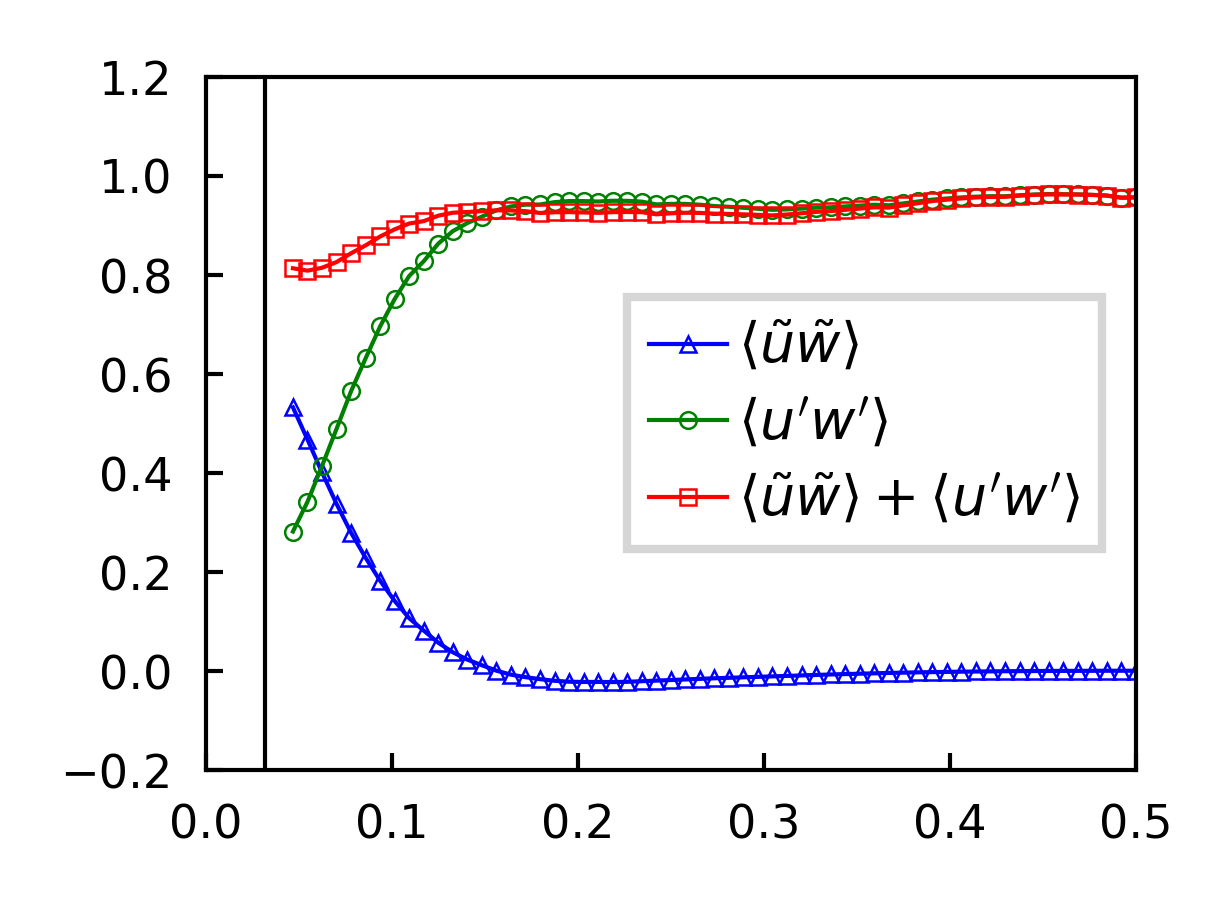

In [27]:
fig = plt.figure(figsize=[2,1.5]); ax = plt.gca()

wl = 2*np.pi/4
limit = 0.2/4/wl # where crests are

(-uv_wave_1D/0.25**2).where(uv_wave_1D.y>limit+0.01).plot(marker='^', \
                label=r'$\langle \tilde{u}\tilde{w} \rangle $')

uv_turb_1D = uv_turb_1D.mean(['t'])
(-uv_turb_1D/0.25**2).where(uv_turb_1D.y>limit+0.01).plot(marker='o', \
                label=r'$\langle u^{\prime}w^{\prime} \rangle$')
((-uv_wave_1D-uv_turb_1D)/0.25**2).where(uv_wave_1D.y>limit+0.01).plot(marker='s', \
                label=r'$\langle \tilde{u}\tilde{w}\rangle + \langle u^{\prime}w^{\prime} \rangle$') 
plt.axvline(limit, c='k')

ax.set_ylim([-0.2,1.2]) 
ax.set_xlim([0,0.5])
ax.set_xlabel('')
plt.legend()
fig.savefig('../../plots/CU8_stress.pdf')

In [8]:
def forcing (y):
    Ustar = 0.25
    total = Ustar**2*1
    Ha = 2*np.pi-1
    return 4*total / Ha**4 * (Ha - 2*y)**2 * (5*Ha - 4*y)
    
def a(y):
    Ha = 2*np.pi-1
    half = Ha/2.
    return [1 if elem > half else 0 for elem in y]

def plot_NWP(ax):
    z = np.linspace(0, 2*np.pi-1, 100)
    Ustar = 0.25
    Ha = 2*np.pi-1
    total = Ustar**2*1
    wl = 2*np.pi/4
    integral = np.cumsum(forcing(z)*a(z))*(z[1]-z[0])
    ax.plot(z/wl, 1-integral/Ustar**2, '--', c='k', lw=0.5)

def plot_Original(ax):
    z = np.linspace(0, 2*np.pi-1, 100)
    wl = 2*np.pi/4
    ax.plot(z/wl, 1-z/z.max(), '--', c='k', lw=0.5)

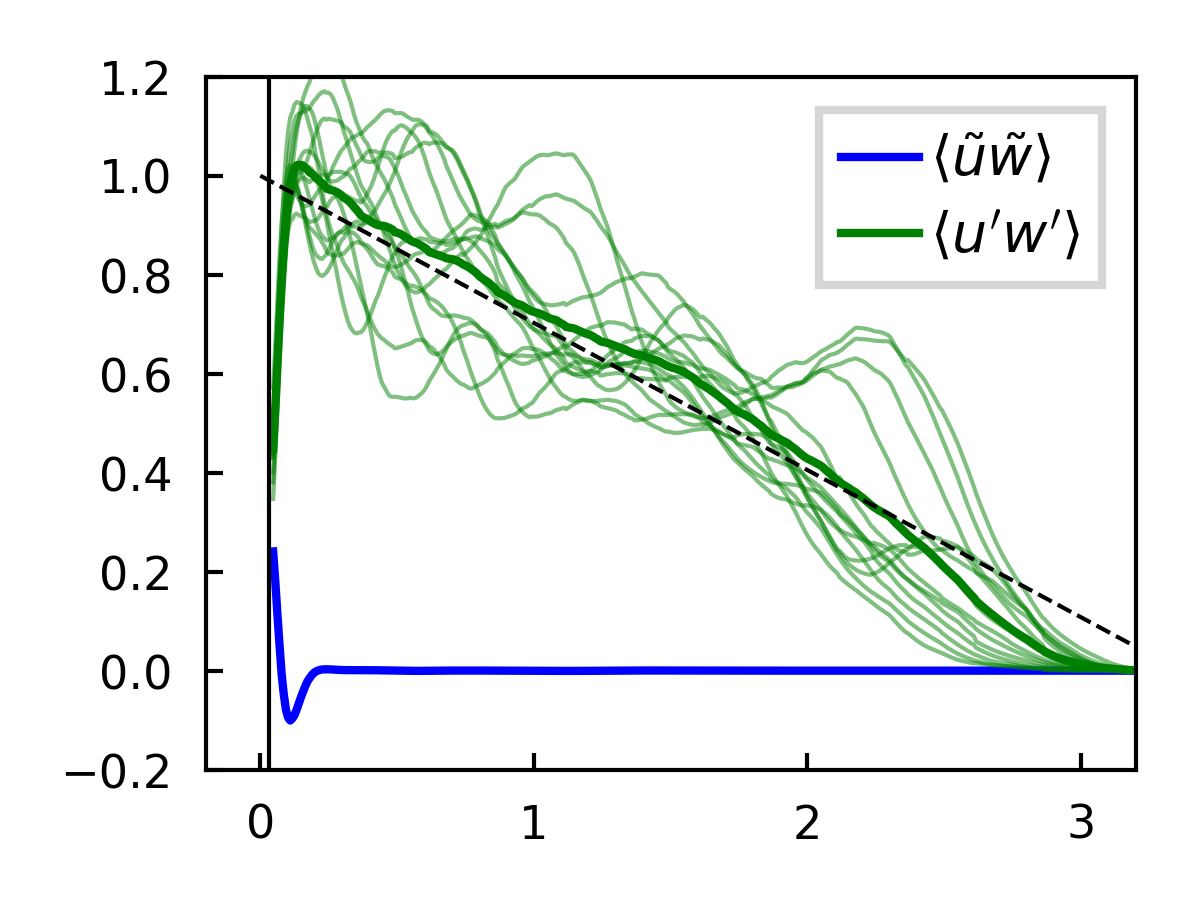

In [9]:
fig = plt.figure(figsize=[2,1.5]); ax = plt.gca()

wl = 2*np.pi/4
limit = 0.2/4/wl # where crests are

(-uv_wave_1D/0.25**2).where(uv_wave_1D.y>limit+0.01).plot(c='b', lw=1, \
                label=r'$\langle \tilde{u}\tilde{w} \rangle $')

for i in range(0,ds_.sizes['t']):
    (-uv_turb_1D.isel(t=i)/0.25**2).where(uv_turb_1D.y>limit+0.01).plot(c='g', lw=0.5, alpha=0.5)
(-uv_turb_1D.mean('t')/0.25**2).where(uv_turb_1D.y>limit+0.01).plot(c='g', lw=1, label=r'$\langle u^{\prime}w^{\prime} \rangle$')

plt.axvline(limit, c='k')
plot_Original(ax)
# plot_NWP(ax)

ax.set_ylim([-0.2,1.2]) 
ax.set_xlim([-0.2,3.2])
ax.set_xlabel('')
plt.legend()
fig.savefig('../../plots/CU4_stress_full.pdf')

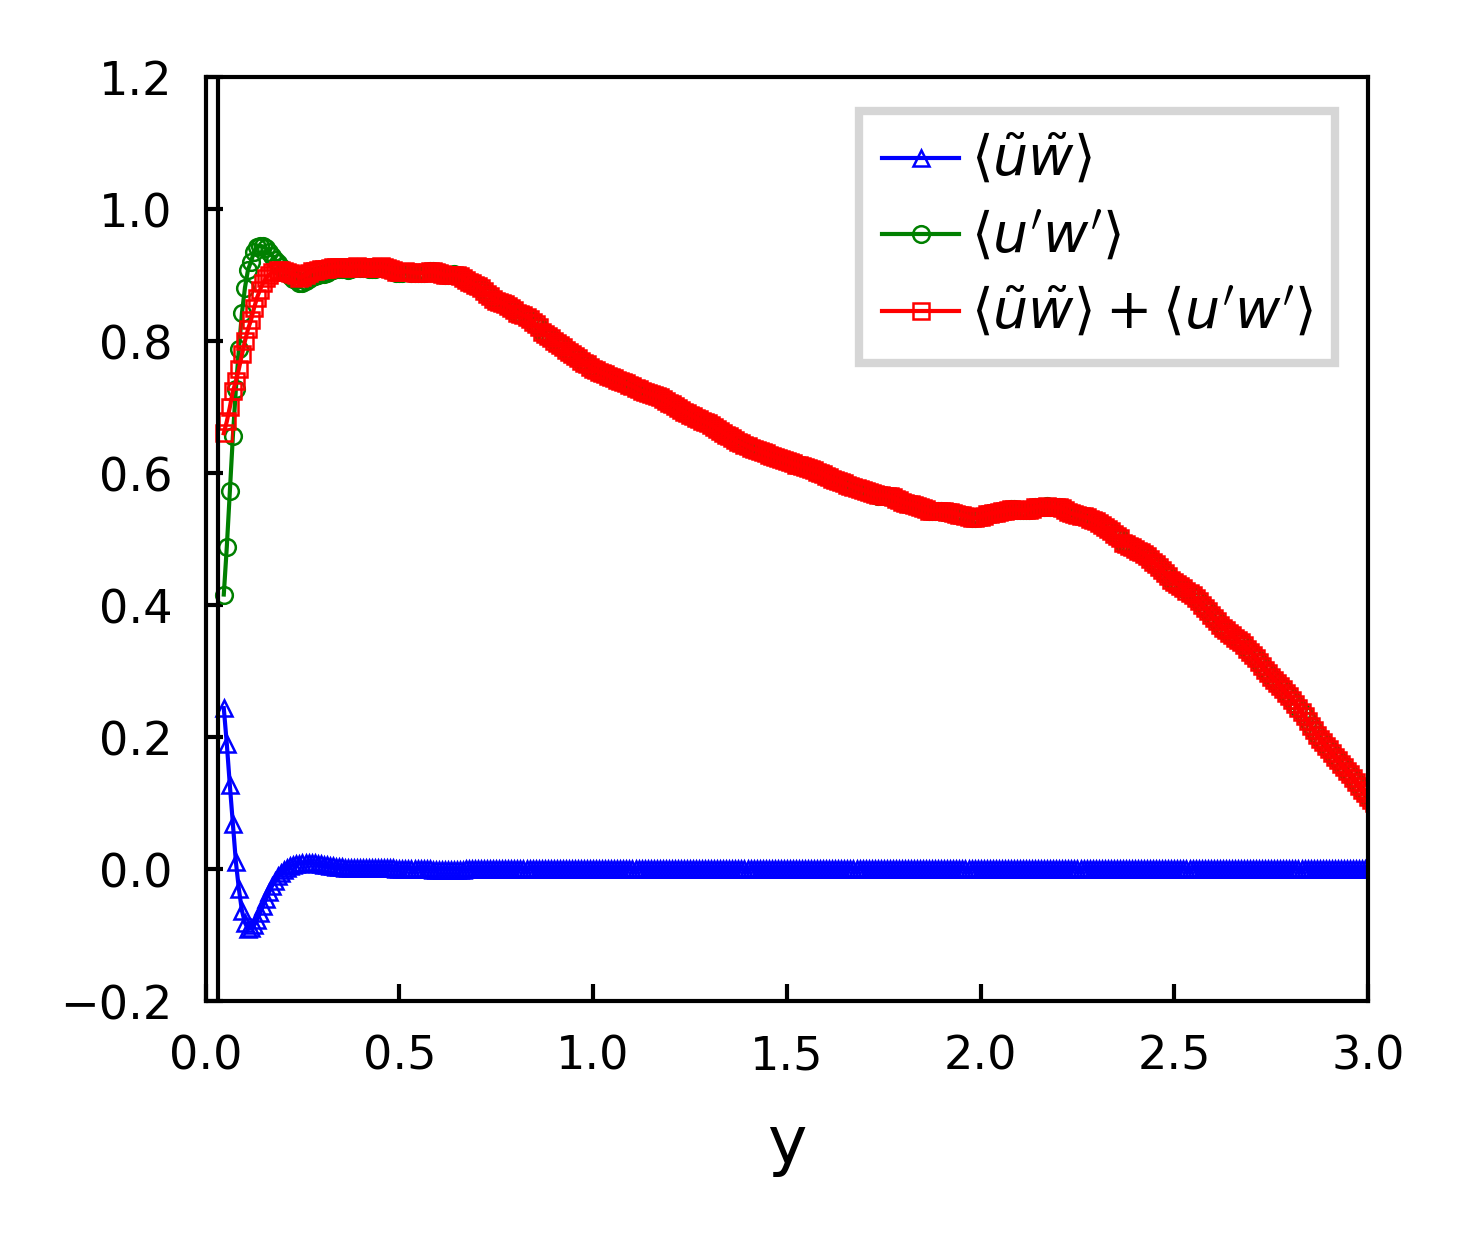

In [158]:
plt.figure(figsize=[2.5,2]); ax = plt.gca()

wl = 2*np.pi/4
limit = 0.2/4/wl # where crests are

(-uv_wave_1D/0.25**2).where(uv_wave_1D.y>limit+0.01).plot(marker='^', \
                label=r'$\langle \tilde{u}\tilde{w} \rangle $')
(-uv_turb_1D/0.25**2).where(uv_turb_1D.y>limit+0.01).plot(marker='o', \
                label=r'$\langle u^{\prime}w^{\prime} \rangle$')
((-uv_wave_1D-uv_turb_1D)/0.25**2).where(uv_wave_1D.y>limit+0.01).plot(marker='s', \
                label=r'$\langle \tilde{u}\tilde{w}\rangle + \langle u^{\prime}w^{\prime} \rangle$') 
plt.axvline(limit, c='k')

ax.set_ylim([-0.2,1.2]); ax.set_xlim([0,3])

plt.legend()

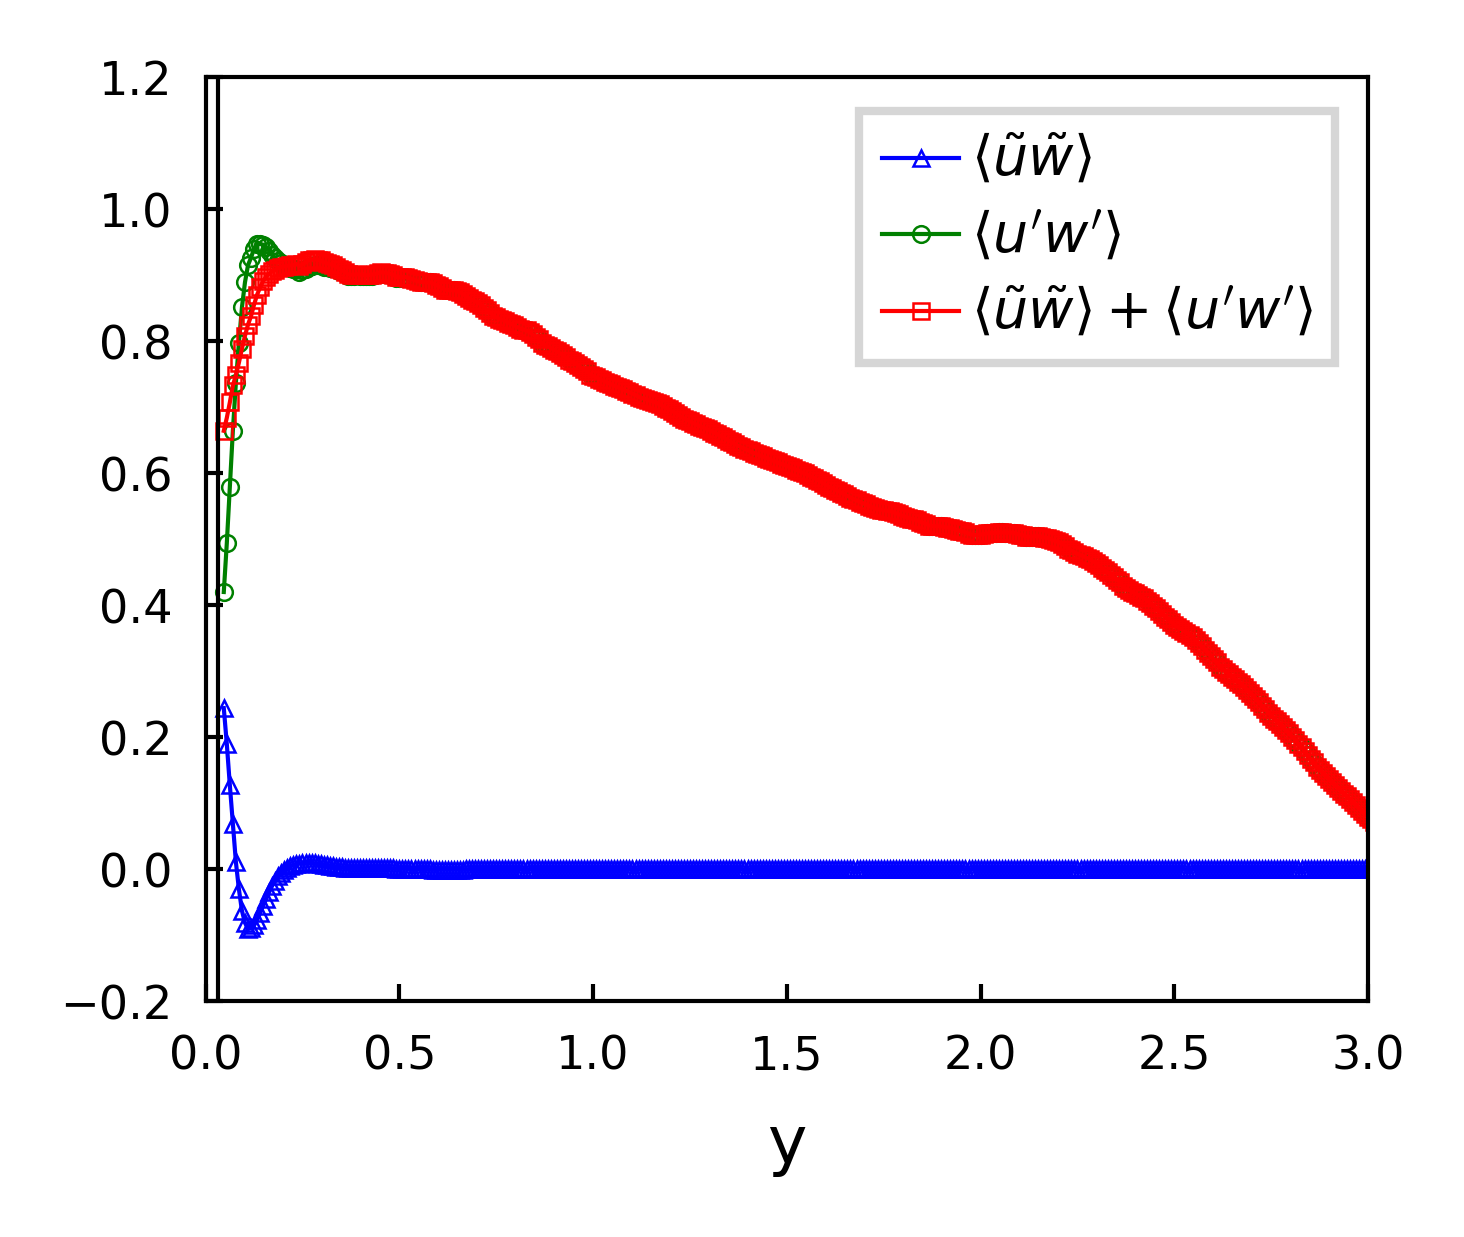

In [181]:
plt.figure(figsize=[2.5,2]); ax = plt.gca()

wl = 2*np.pi/4
limit = 0.2/4/wl # where crests are

(-uv_wave_1D/0.25**2).where(uv_wave_1D.y>limit+0.01).plot(marker='^', \
                label=r'$\langle \tilde{u}\tilde{w} \rangle $')
(-uv_turb_1D/0.25**2).where(uv_turb_1D.y>limit+0.01).plot(marker='o', \
                label=r'$\langle u^{\prime}w^{\prime} \rangle$')
((-uv_wave_1D-uv_turb_1D)/0.25**2).where(uv_wave_1D.y>limit+0.01).plot(marker='s', \
                label=r'$\langle \tilde{u}\tilde{w}\rangle + \langle u^{\prime}w^{\prime} \rangle$') 
plt.axvline(limit, c='k')

ax.set_ylim([-0.2,1.2]); ax.set_xlim([0,3])

plt.legend()